In [6]:
import numpy as np
import pandas as pd

In [7]:
#set number of rows to display
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [8]:
df=pd.read_csv('../BTCUSDT_1min.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

In [9]:
df = df.resample('1h').agg({ 'Open': 'first','High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum' })
df.head()

,Open,High,Low,Close,Volume
timestamp,,,,,
2019-09-16 00:00:00,10302.00,10344.73,10300.36,10327.70,894.623
2019-09-16 01:00:00,10330.50,10353.81,10330.00,10338.57,853.458
2019-09-16 02:00:00,10339.60,10349.88,10325.03,10340.62,807.657
2019-09-16 03:00:00,10339.23,10353.79,10300.00,10300.07,935.050
2019-09-16 04:00:00,10300.24,10319.51,10296.25,10317.29,791.684


In [10]:

def rolling_max_min(df, n):
    df['low_price'] = df['Close'].rolling(window=n,closed='left').min()
    df['high_price'] = df['Close'].rolling(window=n,closed='left').max()
    return df

def generate_signals(df):
    # Calculate the percentage difference
    df['pct'] = (df['low_price'] - df['Close']) / df['Close']
    df['signal'] = 1

    # Apply conditions using vectorized operations
    df.loc[df['Close'] > df['high_price'], 'signal'] = 1
    df.loc[(df['Close'] < df['low_price']) & (df['pct'] > 0.15), 'signal'] = -1
    df.loc[(df['Close'] < df['low_price']) & (df['pct'] < 0.008), 'signal'] = 0

    # Drop the temporary 'pct' column
    df.drop(columns=['pct'], inplace=True)
    
    return df




In [11]:
def low_high_strategy(df, n):

    df = df.copy()
    df = rolling_max_min(df, n)
    df = df[n:]
    df = generate_signals(df)
    df['returns'] = df['Close'].pct_change()
    df['strategy_returns'] = df['signal'].shift(1) * df['returns']
    df['cumulative_returns'] = (1 + df['returns']).cumprod() - 1
    df['cumulative_strategy_returns'] = (1 + df['strategy_returns']).cumprod() - 1
    # Calculate total return
    total_return = df['cumulative_strategy_returns'].iloc[-1]
    

    # Calculate annualized return
    days = (df.index[-1] - df.index[0]).days
    annualized_return = (1 + total_return) ** (365 / days) - 1

    # Calculate Sharpe ratio(first aggregate strategy returns from 5min to daily)
    sharpe_ratio = df['strategy_returns'].mean() / df['strategy_returns'].std() * (df['strategy_returns'].count() ** 0.5)
    # calculate the number of trades
    num_trades = df['signal'].diff().abs().sum()

    # Print results
    #print(f"Total Return: {total_return:.2%}")
    #print(f"Annualized Return: {annualized_return:.2%}")
    #print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    
    return total_return,num_trades

In [12]:
total_returns = []
num_trades = []
n_list = np.arange(1, 1000,1)

for n in n_list:
    total_return, num_trade = low_high_strategy(df, n)
    total_returns.append(total_return)
    num_trades.append(num_trade)

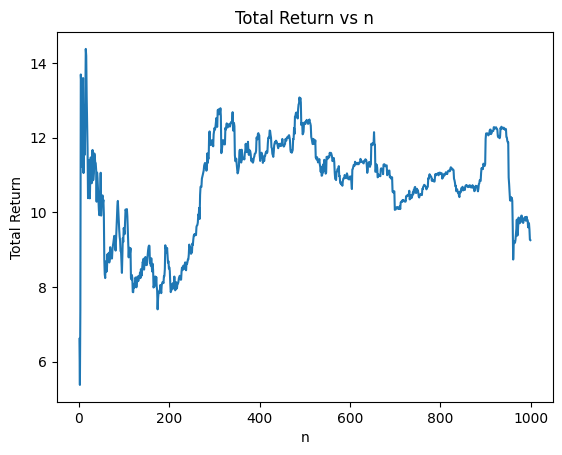

Optimal n: 15


In [13]:
import matplotlib.pyplot as plt

plt.plot(n_list, total_returns)
plt.xlabel('n')
plt.ylabel('Total Return')
plt.title('Total Return vs n')
plt.show()
# get the optimal n
optimal_n = n_list[np.argmax(total_returns)]
print(f'Optimal n: {optimal_n}')

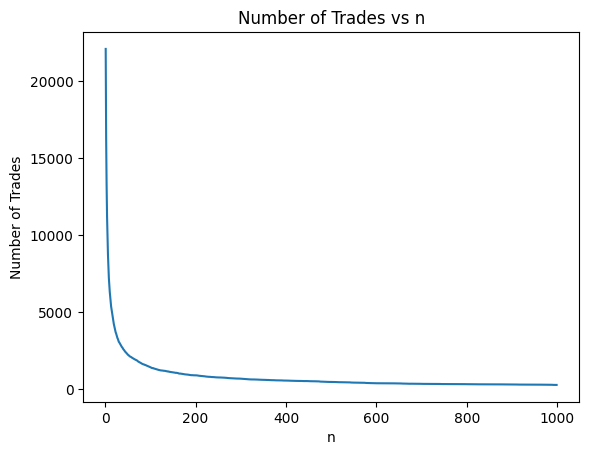

In [14]:
plt.plot(n_list, num_trades)
plt.xlabel('n')
plt.ylabel('Number of Trades')
plt.title('Number of Trades vs n')
plt.show()

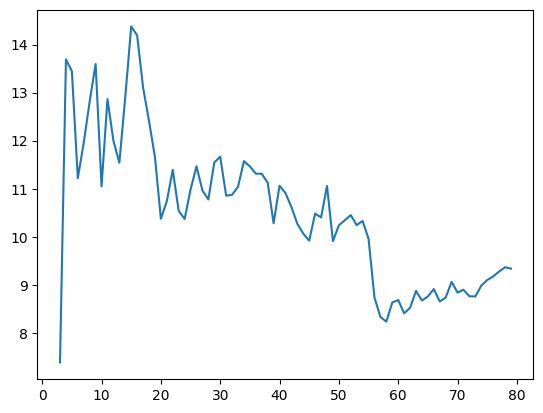

In [15]:
total_returns = []
n_list = np.arange(3,80, 1)

for n in n_list:
    total_returns.append(low_high_strategy(df, n)[0])
    
plt.plot(n_list, total_returns)
plt.show()

In [16]:
n = 490
df = rolling_max_min(df, n)
df = df[n:]
df = generate_signals(df)
df['returns'] = df['Close'].pct_change()
df['strategy_returns'] = df['signal'].shift(1) * df['returns']
df['cumulative_returns'] = (1 + df['returns']).cumprod() - 1
df['cumulative_strategy_returns'] = (1 + df['strategy_returns']).cumprod() - 1
# Calculate total return
total_return = df['cumulative_strategy_returns'].iloc[-1]

# Calculate annualized return
days = (df.index[-1] - df.index[0]).days
annualized_return = (1 + total_return) ** (365 / days) - 1

# Calculate Sharpe ratio(first aggregate strategy returns from 5min to daily)
sharpe_ratio = df['strategy_returns'].mean() / df['strategy_returns'].std() * (df['strategy_returns'].count() ** 0.5)
# Print results
print(f"Total Return: {total_return:.2%}")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Total Return: 1305.94%
Annualized Return: 71.38%
Sharpe Ratio: 2.55


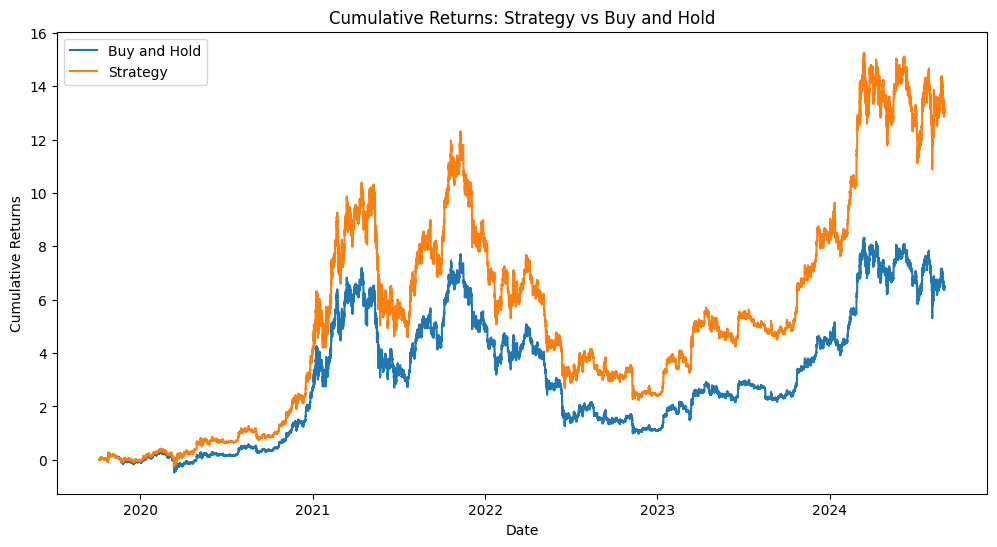

In [17]:

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['cumulative_returns'], label='Buy and Hold')
plt.plot(df.index, df['cumulative_strategy_returns'], label='Strategy')
plt.title('Cumulative Returns: Strategy vs Buy and Hold')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

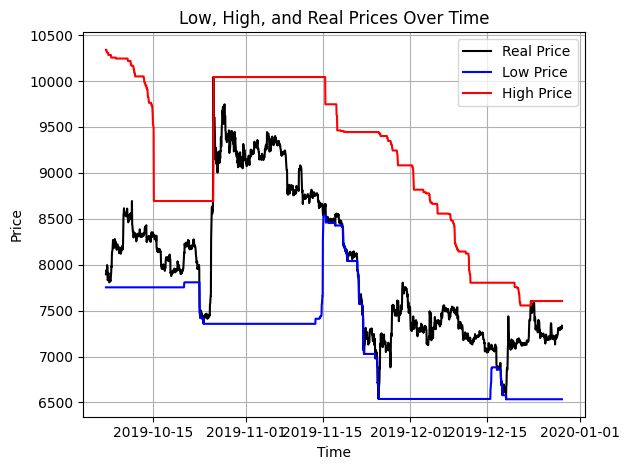

In [18]:
import matplotlib.pyplot as plt

# plot first 100 prices
plt.plot(df['Close'][:2000], label='Real Price', color='black')
plt.plot(df['low_price'][:2000], label='Low Price', color='blue')
plt.plot(df['high_price'][:2000], label='High Price', color='red')

plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Low, High, and Real Prices Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
def load_funding_rate():
    df_funding_rate = pd.read_csv('..\BTCUSDT_funding_rate.csv')
    df_funding_rate['timestamp'] = pd.to_datetime(df_funding_rate['timestamp'], unit='ms')
    df_funding_rate['timestamp'] = df_funding_rate['timestamp'].dt.round('H')
    df_funding_rate.set_index('timestamp', inplace=True)
    return df_funding_rate

df_funding_rate = load_funding_rate()

In [20]:
#change column name 'signal' to 'position'
df = df.rename(columns={'signal': 'position'})
df = df[['Open','Close','position']]
df['position'] = df['position'].astype(int)
df = df.join(df_funding_rate, how='left')
df['position_change'] = df['position'].diff()

In [21]:
taker_fee = 0.0500 / 100
maker_fee = 0.0200 / 100

def calculate_costs(df,taker_fee, maker_fee):
    df['position_change'] = df['position'].diff()
    
    df.loc[df['position_change'] > 0, 'trade_cost'] = df['Close'] * taker_fee * abs(df['position_change'])
    df.loc[df['position_change'] < 0, 'trade_cost'] = df['Close'] * maker_fee * abs(df['position_change'])
    
    df.loc[(df['position'] > 0) & (df['fundingRate'].notnull()), 'funding_cost'] = df['Open'] * df['fundingRate'] * abs(df['position'])
    df.loc[(df['position'] < 0) & (df['fundingRate'].notnull()), 'funding_cost'] = -(df['Open'] * df['fundingRate']) * abs(df['position'])
    
    df['trade_cost'] = df['trade_cost'].fillna(0)
    df['funding_cost'] = df['funding_cost'].fillna(0)
    df['total_cost'] = df['trade_cost'] + df['funding_cost']
    df['total_cost'] = df['total_cost'].fillna(0)
    return df

df = calculate_costs(df, taker_fee, maker_fee)

In [22]:
df.tail()

,Open,Close,position,fundingRate,position_change,trade_cost,funding_cost,total_cost
timestamp,,,,,,,,
2024-08-31 19:00:00,58889.2,58834.2,1,NaN,0.0,0.0,0.0,0.0
2024-08-31 20:00:00,58834.3,58917.8,1,NaN,0.0,0.0,0.0,0.0
2024-08-31 21:00:00,58917.7,59026.7,1,NaN,0.0,0.0,0.0,0.0
2024-08-31 22:00:00,59026.6,58999.0,1,NaN,0.0,0.0,0.0,0.0
2024-08-31 23:00:00,58998.9,58941.9,1,NaN,0.0,0.0,0.0,0.0


In [23]:
df['total_cost'].sum()

31542.932261040303

In [24]:
df['trade_cost'].sum()

4821.757542

In [25]:
df['funding_cost'].sum()

26721.1747190403

In [26]:
df[df['trade_cost'] != 0].shape[0]

461